In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import classifiers.classifier as classifier
import seaborn as sns
import standard_sequences.rabi_tomo as tomo
import analysis.analysis as analysis
import analysis.plotting as plotting
import time
import traceback

KeyboardInterrupt: 

In [ ]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)

Qubit(IQ_angle=60, ef_time=44, ge_amp=1.01, ge_time=77, ro_amp=0.35, mixer_offset_ge=2.5, ef_half_amp_y=1.31, ef_half_amp_x=1.31, qubit_thr=[-10000, -600], mixer_offset_ef=6, ef_ssm=-0.2568, ge_ssm=-0.1144, qubit_id=q1, ef_half_time=25, RO_LO=6.6247, ro_dur=5000, ef_amp=1.53, RO_IF=None, RO_LO_pwr=16, ROIF=0.10268999999999995, ro_freq=6.72739)
Qubit(IQ_angle=25, ef_time=None, ge_amp=0.8, ge_time=74, ro_amp=0.5, mixer_offset_ge=None, ef_half_amp_y=None, ef_half_amp_x=None, qubit_thr=[-10000, 1900], mixer_offset_ef=None, ef_ssm=-0.2962, ge_ssm=-0.154, qubit_id=q2, ef_half_time=None, RO_LO=6.6247, ro_dur=5000, ef_amp=1, RO_IF=None, RO_LO_pwr=16, ROIF=0.030840000000000423, ro_freq=6.65554)


In [ ]:
def run_sweep_ef(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    pi_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
    phase: float,
    amp_start: float,
    amp_stop: float,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    tomo.sweep_pi_ef(
        q1,
        q2,
        general_vals_dict,
        num_steps=num_steps,
        pi_time=pi_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        phase=phase,
        amp_start=amp_start,
        amp_stop=amp_stop,
)
    

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    amp = np.linspace(amp_start, amp_stop, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "amp": amp,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=amp,
    )

    df_pop = pd.DataFrame(
        {
            "time": amp,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=amp,
    )

    return df_prob, df_pop, values



In [ ]:
amp_start = 0
amp_stop = 1.5
num_steps = 151
pi_time = q1.ef_time
swap_freq = -0.0194
swap_time = 0.5 * 7 / abs(swap_freq)
reps = 4000
phase = 0
# Run the experiment and get the probabilities
df_prob, df_pop, values = run_sweep_ef(
    q1,
    q2,
    general_vals_dict,
    num_steps=num_steps,
    pi_time=pi_time,
    swap_freq=swap_freq,
    swap_time=swap_time,
    reps=reps,
    phase=phase,
    amp_start=amp_start,
    amp_stop=amp_stop,
)



writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 151
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 151
Records per pattern: 4000
Buffers per acquistion: 197
DAQ samples per pattern: 8192
0, No error
Capturing 197 buffers. Press <enter> to abort
Capture completed in 69.734614 sec
Captured 197 buffers (2.824996 buffers per sec)
Captured 605184 records (8678.387418 records per sec)
Transferred 9915334656 bytes (142186699.464207 bytes per sec)


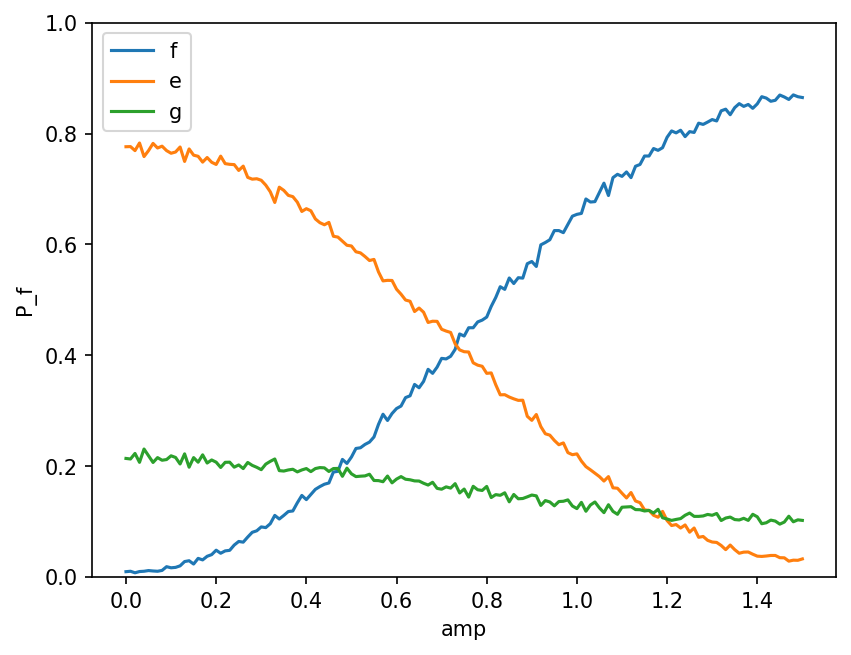

In [ ]:
plt.figure(dpi=150)
sns.lineplot(data=df_prob, x="amp", y="P_f", label="f")
sns.lineplot(data=df_prob, x="amp", y="P_e", label="e")
sns.lineplot(data=df_prob, x="amp", y="P_g", label="g")
plt.legend()
plt.ylim(0, 1)
plt.show()

In [ ]:
# IQ_df = plotting.get_IQ_averages(values)
# Q_1 = IQ_df["Q1"]
# I_1 = IQ_df["I1"]
# Q_2 = IQ_df["Q2"]
# I_2 = IQ_df["I2"]
# # Plot the IQ data
# max_idx=np.unravel_index(np.argmax(I_1), I_1.shape)
# amp_list =np.linspace(amp_start, amp_stop, num_steps)
# amp_min =   amp_list[max_idx[0]]
# plt.plot(df_prob["amp"],I_1)
# plt.axhline(I_1[0])
# # plt.axvline(amp_min, color="red", linestyle="--", label="Minimum e state at {:.2f} V".format(amp_min))
# plt.xlim(1.2,1.4)
# plt.legend()
# plt.title("I1")
# plt.show()
# plt.plot(df_prob["amp"],Q_1)
# plt.axhline(Q_1[0])
# plt.xlim(1.2,1.4)
# # plt.axvline(amp_min, color="red", linestyle="--", label="Minimum e state at {:.2f} V".format(amp_min))
# plt.legend()
# plt.title("Q1")
# plt.show()
# plt.plot(df_prob["amp"],I_2)
# plt.axhline(I_2[0])
# plt.axvline(1.43)
# plt.xlim(1.2,1.5)
# # plt.axvline(amp_min, color="red", linestyle="--", label="Minimum e state at {:.2f} V".format(amp_min))
# plt.legend()
# plt.title("I2")
# plt.show()
# plt.plot(df_prob["amp"],Q_2)
# plt.axhline(Q_2[0])
# plt.xlim(1.2,1.5)
# # plt.axvline(amp_min, color="red", linestyle="--", label="Minimum e state at {:.2f} V".format(amp_min))
# plt.legend()
# plt.title("Q2")
# plt.show()




In [ ]:
# normalized_f = df_prob["P_f"] / (df_prob["P_f"] + df_prob["P_e"])
# normalized_e = df_prob["P_e"] / (df_prob["P_f"] + df_prob["P_e"])
# P_matrix = np.array([normalized_f,normalized_e])

# scale_matrix_inv = np.array([
#     [-0.00972053 , 1.00972053],
#     [ 1.00972053 ,-0.00972053]
# ])
# P_matrix= np.matmul(scale_matrix_inv,P_matrix)
# normalized_f = P_matrix[0]
# normalized_e = P_matrix[1]
# max_idx=np.unravel_index(np.argmin(normalized_f), normalized_f.shape)
# amp_list =np.linspace(amp_start, amp_stop, num_steps)
# amp_min =   amp_list[max_idx[0]]
# plt.figure(dpi=150)
# plt.plot(df_prob["amp"]+1, normalized_f, label="f state")
# plt.plot(df_prob["amp"]+1, normalized_e, label="e state")
# # plt.axvline(amp_min, color="red", linestyle="--", label="Minimum e state at {:.2f} V".format(amp_min))
# plt.axhline(0.5, color="black", linestyle="--", label="50%")
# plt.axvline(1.29)
# plt.xlabel("Amplitude (V)")
# plt.ylabel("Probability")
# plt.legend()
# plt.show()

